In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.impute import SimpleImputer

from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.dataset.CMAPSS import (CMAPSSDataset)
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.transformation.transformers import Transformer, transformation_pipeline, numericals_pipeline
from rul_pm.transformation.features.selection import (
    ByNameFeatureSelector,
    PandasVarianceThreshold,
    PandasNullProportionSelector)
from rul_pm.transformation.features.generation import (
    OneHotCategoricalPandas,
    EWMAOutOfRange,
    Accumulate,
    RollingStatistics)
from rul_pm.transformation.transformerstep import Concatenate as ConcatenateStep
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.imputers import ForwardFillImputer, PandasMeanImputer
from rul_pm.transformation.features.scalers import PandasMinMaxScaler

from rul_pm.transformation.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import get_batcher
from rul_pm.models.keras.simple import FCN


from rul_pm.transformation.transformers import Transformer, transformation_pipeline, LivesPipeline
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.imputers import ForwardFillImputer, PandasRemoveInf, PerColumnImputer
from rul_pm.transformation.utils import IdentityTransformer
from rul_pm.graphics.plots import plot_true_vs_predicted


# 1. Loading data

In [26]:
train_dataset = CMAPSSDataset(train=True, models=['FD001', 'FD002'])
validation_dataset = CMAPSSDataset(train=False, models=['FD001', 'FD002'])

# 2. Features available

In [27]:
pd.DataFrame(train_dataset[0].columns)

,0
0,Cycle
1,OpSet1
2,OpSet2
3,OpSet3
4,SensorMeasure1
5,SensorMeasure2
6,SensorMeasure3
7,SensorMeasure4
8,SensorMeasure5
9,SensorMeasure6


# 2. Transformation

## 2.1 Data Pipeline

### 2.1.1 Raw features

In [28]:
raw_pipe = ByNameFeatureSelector(['SensorMeasure9', 'SensorMeasure12'])
raw_pipe = IQROutlierRemover(1.5, 1)(raw_pipe)
raw_pipe = ForwardFillImputer()(raw_pipe)
raw_pipe = PandasMinMaxScaler((-1,1), name='RawFeatures')(raw_pipe)

### 2.1.2 Categorical features
In this case we have the Engine feature as a categorical we will use one hot encoding. In this case each life we have a constant column either with 1 or 0

In [29]:
cat_pipe = OneHotCategoricalPandas('Engine')

### 2.1.3 Composable feature extraction

In [30]:
ewma_pipe = ByNameFeatureSelector(['OpSet1', 'OpSet2'])
ewma_pipe = EWMAOutOfRange(0.2)(ewma_pipe)
ewma_pipe = Accumulate()(ewma_pipe)
ewma_pipe = PandasMinMaxScaler((-1,1), name='OutOfRange')(ewma_pipe)

### 2.1.5 Rolling statistics

In [33]:
rolling_pipe = ByNameFeatureSelector(['SensorMeasure3', 'SensorMeasure2'])
rolling_pipe = RollingStatistics(50)(rolling_pipe)
rolling_pipe = PandasNullProportionSelector(0.5)(rolling_pipe)
rolling_pipe = PandasMinMaxScaler((-1,1))(rolling_pipe)
rolling_pipe = PandasTransformerWrapper(
    SimpleImputer(fill_value=-2, strategy='constant'),
    name='Rolling50')(rolling_pipe)

### 2.1.4 Concatenate

In [34]:
pipe = ConcatenateStep()([cat_pipe, raw_pipe, ewma_pipe, rolling_pipe])

## 2.2 Target pipeline

In [35]:
target_pipe = ByNameFeatureSelector(['RUL'])

## Build the transformer

In [36]:
transformer = Transformer(
    transformerX=pipe.build(),
    transformerY=target_pipe.build())

# 3. Fit the transformer

In [37]:
transformer.fit(train_dataset)

# 4. View the transformed data

In [38]:
X = transformer.transformerX.transform(train_dataset[1])

In [39]:
X

,OneHotCategoricalPandas_0_FD001,OneHotCategoricalPandas_0_FD002,RawFeatures_1_SensorMeasure9,RawFeatures_1_SensorMeasure12,OutOfRange_2_OpSet1,OutOfRange_2_OpSet2,Rolling50_3_SensorMeasure3_max,Rolling50_3_SensorMeasure3_min,Rolling50_3_SensorMeasure3_peak,Rolling50_3_SensorMeasure3_std,...,Rolling50_3_SensorMeasure2_rms,Rolling50_3_SensorMeasure2_crest,Rolling50_3_SensorMeasure2_shape,Rolling50_3_SensorMeasure2_clearance,Rolling50_3_SensorMeasure2_kurtosis,Rolling50_3_SensorMeasure2_skewness,Rolling50_3_SensorMeasure2_fft_centroid,Rolling50_3_SensorMeasure2_fft_variance,Rolling50_3_SensorMeasure2_ps_centroid,Rolling50_3_SensorMeasure2_ps_variance
192,1,0,0.698387,0.994674,-1.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
193,1,0,0.692970,0.996550,-1.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
194,1,0,0.697624,0.995942,-1.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
195,1,0,0.703613,0.995485,-1.000000,-0.964912,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
196,1,0,0.703835,0.994369,-1.000000,-0.964912,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,1,0,0.745105,0.983209,-0.255319,-0.157895,0.887148,0.977219,-0.918152,-0.966763,...,0.994655,-0.986745,-0.999924,-0.986770,-0.670017,0.053496,-0.987993,-0.986710,-0.987993,-0.986710
475,1,0,0.754223,0.982600,-0.255319,-0.157895,0.887148,0.977219,-0.918152,-0.966216,...,0.995026,-0.986746,-0.999924,-0.986770,-0.701441,0.014762,-0.988610,-0.987640,-0.988610,-0.987640
476,1,0,0.768203,0.982397,-0.255319,-0.157895,0.887148,0.977219,-0.918152,-0.968271,...,0.995216,-0.986746,-0.999848,-0.986771,-0.715747,0.023879,-0.988272,-0.987192,-0.988272,-0.987192
477,1,0,0.773508,0.980368,-0.255319,-0.157895,0.887148,0.977219,-0.918152,-0.968570,...,0.995686,-0.986747,-0.999848,-0.986772,-0.729835,-0.000844,-0.988775,-0.987676,-0.988775,-0.987676


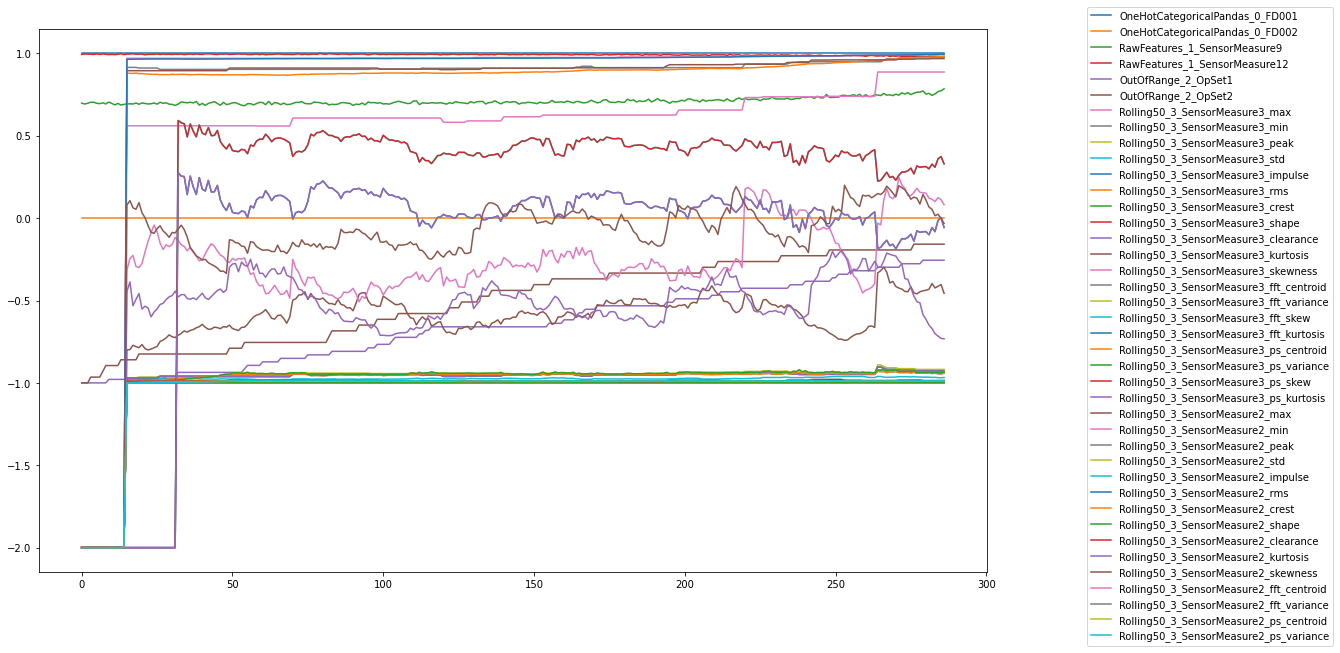

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(17, 10))
for c in X.columns:
    ax.plot(X[c].values, label=c)

ax.legend(bbox_to_anchor=(1.1, 1.05))